In [138]:
import time
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from dtw import dtw

tf.disable_v2_behavior()

# Preprocessing data

In [139]:
all_x = scipy.io.loadmat('./dataset/timeseries/Trace_data.mat')['data']
all_y = scipy.io.loadmat('./dataset/timeseries/Trace_label.mat')['label'][0]

In [140]:
x, y = [], []

class_1 = 1
class_2 = 4

for i in range(len(all_x)):
  if all_y[i] == class_1 or all_y[i] == class_2:
    x.append(all_x[i][:200])
    y.append(all_y[i])

x = np.array(x)
y = np.array(y)
y = np.where(y == class_2, -1, 1)
y = y.reshape(-1, 1)

print(x)
print(y)

[[ 0.56421375  0.54511617  0.54204671 ...  0.23900864  0.2035571
   0.20117864]
 [ 0.6376156   0.58507817  0.62313348 ...  0.32094571  0.2853001
   0.25950175]
 [-1.4043092  -1.4425306  -1.415186   ...  0.74640323  0.6894699
   0.76927325]
 ...
 [ 0.64550395  0.57923708  0.64327477 ...  0.51632464  0.52290732
   0.55828421]
 [ 0.57311057  0.66785286  0.6204376  ...  0.5212762   0.51004323
   0.5036782 ]
 [-1.4311198  -1.4549623  -1.4688949  ...  0.74562151  0.73998126
   0.76169572]]
[[ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [ 1]
 [-1]]


In [141]:
# Split test / train
train_cnt = 33

np.random.seed(10)
train_index = np.random.choice(len(x), size=train_cnt, replace=False)
print(train_index)
test_index = [i for i in np.arange(0, len(x)) if i not in train_index]

train_x = x[train_index]
train_y = y[train_index]

test_x = x[test_index]
test_y = y[test_index]

print(np.shape(train_x))
print(np.shape(test_x))

[31 21 27  7 32 24  2 17 18 20 12  6 33  3 26  5 13 14 37 30  1 23 35 11
 40 38 16 19  4 22 34 10 39]
(33, 200)
(10, 200)


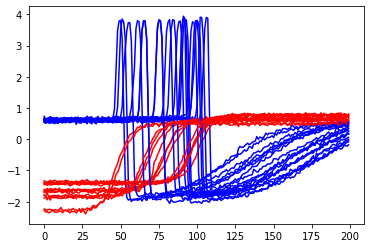

In [142]:
for i in range(len(train_x)):
  plt.plot(train_x[i].ravel(), 'b' if train_y[i] == 1 else 'r')
plt.show()

1
1
-1
-1
-1
1
1
-1
1
-1


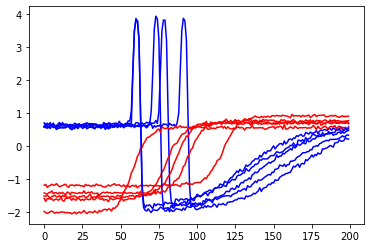

In [143]:
for i in range(len(test_x)):
  print(test_y[i][0])
  plt.plot(test_x[i].ravel(), 'b' if test_y[i] == 1 else 'r')
plt.show()

In [144]:
batch = int(np.shape(train_x)[0] / 2)
batch = int(np.shape(train_x)[0])
iter = 5
lr = 0.01
gamma = 1.8

In [145]:
X = tf.placeholder(shape=[None, None], dtype=tf.float32)
pred_X = tf.placeholder(shape=[None, None], dtype=tf.float32)
test_X = tf.placeholder(shape=[None, None], dtype=tf.float32)

Y = tf.placeholder(shape=[None, 1], dtype=tf.float32)
test_Y = tf.placeholder(shape=[None, 1], dtype=tf.float32)

B = tf.Variable(tf.random_uniform(shape=[1, batch]))

In [146]:
def _dtw(X1, X2):
  dtw_array = []
  for i in range(len(X1)):
    tmp_i = []
    for j in range(len(X2)):
      distance = fastdtw(X1[i], X2[j], dist=euclidean)
      tmp_i.append(distance[0])

    dtw_array.append(tmp_i)

  return dtw_array

In [147]:
G = tf.constant(gamma)
dtw_distances = tf.py_function(func=_dtw, inp=[X, X], Tout=[tf.float32 for i in range(batch)])

kernel = tf.exp(-tf.multiply(G, dtw_distances))

In [148]:
first_term = tf.reduce_sum(B)

second_term = tf.reduce_sum(
  tf.multiply(
    kernel,
    tf.multiply(
      tf.matmul(tf.transpose(B), B),
      tf.matmul(Y, tf.transpose(Y))
    )
  )
)

loss = tf.negative(tf.subtract(first_term, second_term))

In [149]:
pred_dtw_distances = tf.py_function(func=_dtw, inp=[X, pred_X], Tout=[tf.float32 for i in range(batch)])
pred_kernel = tf.exp(-tf.multiply(G, pred_dtw_distances))

prediction_output = tf.matmul(tf.multiply(tf.transpose(Y), B), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(Y)), tf.float32))

In [150]:
test_dtw_distances = tf.py_function(func=_dtw, inp=[X, test_X], Tout=[tf.float32 for i in range(batch)])
test_kernel = tf.exp(-tf.multiply(G, test_dtw_distances))

test_prediction_output = tf.matmul(tf.multiply(tf.transpose(Y), B), test_kernel)
test_prediction = tf.sign(test_prediction_output - tf.reduce_mean(test_prediction_output))

test_accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(test_prediction), tf.squeeze(test_Y)), tf.float32))

In [151]:
optimizer = tf.train.GradientDescentOptimizer(lr)
train = optimizer.minimize(loss)
init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

In [152]:
start = time.time()

loss_vec = []
batch_accuracy = []

rand_index = []
for i in range(iter):
  print('Step #' + str(i+1))
  local_start = time.time()

  rand_index = np.random.choice(len(train_x), size=batch, replace=False)
  rand_x = train_x[rand_index]
  rand_y = train_y[rand_index]

  sess.run(train, feed_dict={X: rand_x, Y: rand_y})
  temp_loss = sess.run(loss, feed_dict={X: rand_x, Y: rand_y})
  loss_vec.append(temp_loss)

  acc_temp = sess.run(accuracy, feed_dict={X: rand_x, Y: rand_y, pred_X: rand_x})
  batch_accuracy.append(acc_temp)

  print("accuracy :", acc_temp)
  print("loss:", str(temp_loss))
  print("time :", time.time() - local_start)

print("Total time :", time.time() - start)

Step #1
accuracy : 0.90909094
loss: -5.2102394
time : 163.98379588127136
Step #2
accuracy : 0.90909094
loss: -5.330449
time : 155.5307641029358
Step #3
accuracy : 0.93939394
loss: -5.4464808
time : 155.3102719783783
Step #4
accuracy : 1.0
loss: -5.5568132
time : 156.4461009502411
Step #5
accuracy : 0.969697
loss: -5.663086
time : 151.06179904937744
Total time : 782.33358502388


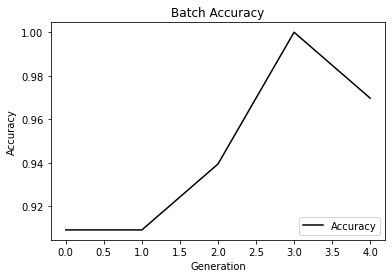

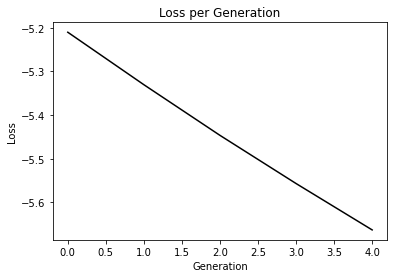

In [153]:
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [154]:
test_preds = sess.run(test_prediction,
                      feed_dict={
                          X: train_x[rand_index],
                          Y: train_y[rand_index],
                          test_X: test_x
                      })

In [ ]:
test_acc = sess.run(test_accuracy,
                      feed_dict={
                          X: train_x[rand_index],
                          Y: train_y[rand_index],
                          test_X: test_x,
                          test_Y: test_y
                      })

In [ ]:
print(test_acc)

In [ ]:
test_preds = np.squeeze(test_preds)
_test_y = np.squeeze(test_y)

colors = []
cnt = 0
for i in range(len(test_preds)):
  if test_preds[i] == _test_y[i]:
    cnt += 1
    colors.append('b')

  else:
    colors.append('r')

print(cnt)
print(cnt / len(test_preds))


## Influence function

### Gradient for target data

In [97]:
inf_x = tf.placeholder(shape=[None, None], dtype=tf.float32)
inf_dtw_distances = tf.py_function(func=_dtw, inp=[x, inf_x], Tout=[tf.float32 for i in range(batch)])
inf_kernel = tf.exp(-tf.multiply(G, inf_dtw_distances))

In [98]:
inf_kernel_value = sess.run(inf_kernel,
                            feed_dict={X: train_x[rand_index],
                                       inf_x: [test_x[0]]})

In [112]:
inf_first_term = tf.reduce_sum(B)

inf_second_term = tf.reduce_sum(
  tf.multiply(
    inf_kernel,
    tf.multiply(
      tf.matmul(tf.transpose(B), B),
      tf.matmul(Y, tf.transpose(Y))
    )
  )
)

inf_loss = tf.negative(tf.subtract(inf_first_term, inf_second_term))
inf_gradient = tf.gradients(inf_loss, [B])
inf_hessian = tf.hessians(inf_loss, [B])

In [118]:
target_gradient = sess.run(inf_gradient,
                           feed_dict={
                             X: train_x[rand_index],
                             Y: train_y[rand_index],
                             inf_x: [test_x[0]]})

target_gradient = np.squeeze(target_gradient)

In [123]:
print(target_gradient[0])
print(target_gradient[1])
print(np.shape(target_gradient))
# print(np.shape(rand_index))
# print(rand_index)

[[ 3.6828866  -0.5475874  -0.54759395 -0.54759395 -1.452406   -1.4525495
  -0.54759395 -1.452406   -1.4524186  -0.54759395 -0.54759395 -1.452406
  -0.54759395 -1.4524175  -1.452406   -0.54759395 -1.452406   -0.54759395
  -0.54759395 -1.452406   -0.54759395 -0.54758996 -0.5475939  -0.5475503
  -0.5475694  -0.54759395 -1.4524074  -0.54759264 -1.452406   -1.4524062
  -1.452406   -0.54759395 -1.452406  ]]
2.8926126e-05
(2,)


In [64]:
R = 10
s_test = 0
for r in range(R):
  v = target_gradient
  s_test_j = v
  for i in range(len(rand_index)):
    print('# R: ', (r+1))
    print('# train: ', (i+1))
    train_x_hessian = sess.run(inf_hessian,
                               feed_dict={
                                X: train_x[rand_index],
                                Y: train_y[rand_index],
                                inf_x: [train_x[i]]
                               })
    train_x_hessian = np.squeeze(train_x_hessian)
    train_x_hessian = np.diag(train_x_hessian)
    train_x_hessian = np.identity(np.shape(train_x_hessian)[0]) - train_x_hessian

    s_test_j = v + np.matmul(train_x_hessian, s_test_j)
  s_test += s_test_j

s_test = s_test / R

infs = []
for i in range(len(rand_index)):
  train_x_gradient = sess.run(inf_gradient,
                              feed_dict={
                                X: train_x[rand_index],
                                Y: train_y[rand_index],
                                inf_x: [train_x[i]]
                              })
  train_x_gradient = np.squeeze(train_x_gradient)
  inf_value = -np.matmul(s_test, train_x_gradient)
  infs.append((rand_index[i], inf_value))

print(infs)

# R:  1
# train:  1
# R:  1
# train:  2
# R:  1
# train:  3
# R:  1
# train:  4
# R:  1
# train:  5
# R:  1
# train:  6
# R:  1
# train:  7
# R:  1
# train:  8
# R:  1
# train:  9
# R:  1
# train:  10
# R:  1
# train:  11
# R:  1
# train:  12
# R:  1
# train:  13
# R:  1
# train:  14
# R:  1
# train:  15
# R:  1
# train:  16
# R:  1
# train:  17
# R:  1
# train:  18
# R:  1
# train:  19
# R:  1
# train:  20
# R:  1
# train:  21
# R:  1
# train:  22
# R:  1
# train:  23
# R:  1
# train:  24
# R:  1
# train:  25
# R:  1
# train:  26
# R:  1
# train:  27
# R:  1
# train:  28
# R:  1
# train:  29
# R:  1
# train:  30
# R:  1
# train:  31
# R:  1
# train:  32
# R:  1
# train:  33
# R:  2
# train:  1
# R:  2
# train:  2
# R:  2
# train:  3
# R:  2
# train:  4
# R:  2
# train:  5
# R:  2
# train:  6
# R:  2
# train:  7
# R:  2
# train:  8
# R:  2
# train:  9
# R:  2
# train:  10
# R:  2
# train:  11
# R:  2
# train:  12
# R:  2
# train:  13
# R:  2
# train:  14
# R:  2
# train:  15
# R:  2
# 

8
11
32
18
10
12
15
31
26
9


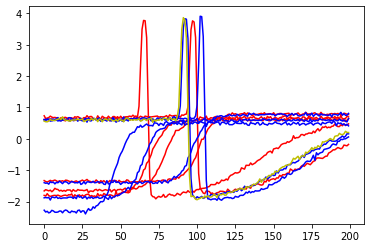

In [82]:
infs = sorted(infs, key=lambda x: x[1])

harmful = infs[:5]
helpful = infs[28:]

for i in range(len(harmful)):
  idx = int(harmful[i][0])
  print(idx)
  plt.plot(train_x[idx], 'r')

for i in range(len(helpful)):
  idx = int(helpful[i][0])
  print(idx)
  plt.plot(train_x[idx], 'b')

plt.plot(test_x[0], 'y')
plt.show()

In [86]:
inf_hessian2 = tf.hessians(loss, [B])

hessian = sess.run(inf_hessian2, feed_dict={X: train_x[rand_index], Y: train_y[rand_index]})
hessian = np.squeeze(hessian)
inv_hessian = np.linalg.inv(hessian)
print(inv_hessian)

[[ 5.00000060e-01 -6.45102318e-08 -1.10607186e-06 ...  0.00000000e+00
  -1.98378576e-08  0.00000000e+00]
 [-6.45102318e-08  5.00000000e-01 -5.38164713e-05 ...  0.00000000e+00
  -5.63307476e-05  0.00000000e+00]
 [-1.10607186e-06 -5.38164713e-05  5.00000000e-01 ...  0.00000000e+00
  -1.28694255e-05  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  5.00000000e-01
   0.00000000e+00 -6.80990752e-06]
 [-1.98378576e-08 -5.63307476e-05 -1.28694255e-05 ...  0.00000000e+00
   5.00000000e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -6.80990752e-06
   0.00000000e+00  5.00000238e-01]]


In [94]:
inf2 = []
for i in range(len(rand_index)):
  train_x_gradient = sess.run(inf_gradient,
                              feed_dict={
                                X: train_x[rand_index],
                                Y: train_y[rand_index],
                                inf_x: [train_x[i]]
                              })
  train_x_gradient = np.squeeze(train_x_gradient)

  inf2.append((rand_index[i], -np.matmul(np.matmul(target_gradient, inv_hessian), train_x_gradient)))

8
11
32
18
10
15
25
31
26
9


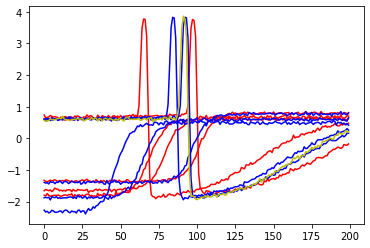

In [95]:
inf2 = sorted(inf2, key=lambda x: x[1])

harmful = inf2[:5]
helpful = inf2[28:]

for i in range(len(harmful)):
  idx = int(harmful[i][0])
  print(idx)
  plt.plot(train_x[idx], 'r')

for i in range(len(helpful)):
  idx = int(helpful[i][0])
  print(idx)
  plt.plot(train_x[idx], 'b')

plt.plot(test_x[0], 'y')
plt.show()

In [96]:
print(inf2)

[(8, -18.054014), (11, -17.9812), (32, -17.755602), (18, -17.547703), (10, -17.41878), (2, -16.837029), (0, -16.269186), (19, -15.940044), (21, -15.89849), (14, -15.788987), (20, -15.5675125), (4, -15.503986), (5, -15.368158), (27, -15.16995), (6, -15.015499), (24, -14.996729), (29, -14.049635), (1, -13.996593), (3, -13.837455), (12, -13.711437), (23, -13.252079), (17, -13.251828), (16, -13.25121), (7, -13.2511835), (30, -13.251164), (22, -13.251085), (28, -13.251077), (13, -12.696638), (15, -12.679486), (25, -12.51655), (31, -11.259474), (26, -10.640811), (9, -10.626679)]


In [132]:
###
inf_pred_output = tf.matmul(tf.multiply(tf.transpose(Y), B), inf_kernel)

inf2_gradient = tf.gradients(inf_pred_output, [B])


In [135]:
grad = sess.run(inf2_gradient, feed_dict={
                             X: train_x[rand_index],
                             Y: train_y[rand_index],
                             inf_x: [test_x[0]]})
print(grad)

[array([[ 9.9999315e-01,  1.5475248e-06,  0.0000000e+00,  0.0000000e+00,
        -7.8599340e-09, -3.3912365e-05,  0.0000000e+00, -0.0000000e+00,
        -2.9621049e-06,  0.0000000e+00,  0.0000000e+00, -1.3507177e-08,
         0.0000000e+00, -2.7081951e-06, -0.0000000e+00,  0.0000000e+00,
        -0.0000000e+00,  3.9112366e-11,  0.0000000e+00, -0.0000000e+00,
         0.0000000e+00,  9.4457300e-07,  9.2572927e-09,  1.0315233e-05,
         5.8110409e-06,  0.0000000e+00, -3.0476059e-07,  3.1424347e-07,
        -2.8989713e-11, -3.8723535e-08, -0.0000000e+00,  1.1503977e-12,
        -0.0000000e+00]], dtype=float32)]


In [137]:
inf2_hessians = tf.hessians(inf_pred_output, [B])

ValueError: None values not supported.